In [1]:
# @title Install Dependancies

# !pip install adlfs > /dev/null 2>&1 && echo $?
# !pip install pyarrow > /dev/null 2>&1 && echo $?
# !pip install praw > /dev/null 2>&1 && echo $?
# !pip install transformers > /dev/null 2>&1 && echo $?
# !pip install retry > /dev/null 2 > & 1 & & echo $?

In [2]:
# @title Import Dependencies


import datetime as dt
import hashlib
import json
import os
import random
from datetime import datetime

import pandas
import pandas as pd
import praw
import pyarrow
import requests
from PIL import Image
from adlfs import AzureBlobFileSystem
from retry import retry
from tqdm import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration

In [3]:
# @title Initialize Secrets

reddit: praw.Reddit = praw.Reddit(client_id='5hVavL0PIRyM_1JSvqT6UQ', client_secret='BjD2kS3WNLnJc59RKY-JJUuc_Z9-JA',
								  user_agent='script:%(bot_name)s:v%(bot_version)s (by /u/%(bot_author)s)',
								  check_for_async=False)

os.environ["AZURE_STORAGE_ACCOUNT_NAME"] = "ajdevreddit"

os.environ[
	"AZURE_STORAGE_ACCOUNT_KEY"] = "+9066TCgdeVignRdy50G4qjmNoUJuibl9ERiTGzdV4fwkvgdV3aSVqgLwldgZxj/UpKLkkfXg+3k+AStjFI33Q=="

os.environ[
	"AZURE_STORE_ACCOUNT_KEY"] = "+9066TCgdeVignRdy50G4qjmNoUJuibl9ERiTGzdV4fwkvgdV3aSVqgLwldgZxj/UpKLkkfXg+3k+AStjFI33Q=="

In [4]:
# @title Initalize Helpers


class BlipCaption:
	def __init__(self, device_name: str = "cuda"):
		self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
		self.device = torch.device(device_name)
		self.model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large",
																  torch_dtype=torch.float16).to(self.device)

	def caption_image(self, image_path: str) -> str:
		try:
			raw_image = Image.open(image_path).convert('RGB')
			inputs = self.processor(raw_image, return_tensors="pt").to(self.device, torch.float16)
			out = self.model.generate(**inputs)
			return self.processor.decode(out[0], skip_special_tokens=True, max_new_tokens=50)

		except Exception as e:
			print(e)
			return ""


class Functions(object):
	def get_name_for_image(self, x: object, file_list__) -> str:
		path = x['path']
		if path != "" and path in file_list__:
			return os.path.basename(path)
		else:
			return ""

	def set_exists(self, x: object, file_system__) -> bool:
		try:
			sub_reddit = x['subreddit']
			record_id = x['id']
			remote_path = x['path']
			return file_system__.exists(remote_path)
		except Exception as ex:
			return False

	def set_hash(self, x: object):
		sub_reddit = x['subreddit']
		record_id = x['id']
		temp_path = f"temp/image/{sub_reddit}/{record_id}.jpg"
		if os.path.exists(temp_path):
			return hashlib.md5(open(temp_path, 'rb').read()).hexdigest()
		else:
			return ""

	def add_source(self, x: object, source_list) -> str:
		sub_reddit = x['subreddit']
		for source in source_list:
			data_source = source['data']
			source_name = source['name']
			if sub_reddit in data_source:
				return source_name
		return ""

	def apply_caption(self, x: object, caption_routine: list[BlipCaption], _file_system: AzureBlobFileSystem) -> str:
		_exists = x['exists']
		if not _exists:
			return ""
		sub_reddit = x['subreddit']
		record_id = x['id']
		remote_path = x['path']
		os.makedirs(f"temp/image/{sub_reddit}/", exist_ok=True)
		temp_path = f"temp/image/{sub_reddit}/{record_id}.jpg"

		if os.path.exists(temp_path):
			try:
				result = random.choice(caption_routine).caption_image(temp_path)
				return result
			except Exception as ex:
				message = f"{x['id']}, {x['subreddit']}, Failure in apply_caption, {ex}"
				print(message)
				return ""
		else:
			try:
				_file_system.download(remote_path, temp_path)
				result = random.choice(caption_routine).caption_image(temp_path)
				return result
			except Exception as ex:
				message = f"{x['id']}, {x['subreddit']}, Failure in apply_caption, {ex}"
				print(message)
				return ""

	def fix_path(self, x: object, fl) -> str:
		current_path = x['path']
		exists_ = x['exists']
		if current_path in fl:
			return current_path
		else:
			image_id = x['id']
			if exists_:
				return f"data/image/{image_id}.jpg"
			else:
				return ""


class AzureFileStorageAdapter(object):
	def __init__(self, container_name: str = "data"):
		self.__account_name: str = os.environ["AZURE_STORAGE_ACCOUNT_NAME"]
		self.__account_key: str = os.environ["AZURE_STORAGE_ACCOUNT_KEY"]
		self.container_name: str = container_name

	def get_file_storage(self) -> AzureBlobFileSystem:
		return AzureBlobFileSystem(
			account_name=self.__account_name,
			account_key=self.__account_key,
			container_name=self.container_name)

	def get_file_storage_root(self) -> AzureBlobFileSystem:
		return AzureBlobFileSystem(account_name=self.__account_name, account_key=self.__account_key,
								   container_name=self.container_name)


schema = pyarrow.schema(
	[
		pyarrow.field("id", pyarrow.string()),
		pyarrow.field("subreddit", pyarrow.string()),
		pyarrow.field("author", pyarrow.string()),
		pyarrow.field("title", pyarrow.string()),
		pyarrow.field("caption", pyarrow.string()),
		pyarrow.field("hash", pyarrow.string()),
		pyarrow.field("permalink", pyarrow.string()),
		pyarrow.field("original_url", pyarrow.string()),
		pyarrow.field("image_name", pyarrow.string()),
		pyarrow.field("path", pyarrow.string()),
		pyarrow.field("model", pyarrow.string()),
		pyarrow.field("exists", pyarrow.bool_()),
		pyarrow.field("curated", pyarrow.bool_()),
		pyarrow.field("accept", pyarrow.bool_()),
		pyarrow.field("tags", pyarrow.list_(pyarrow.string()))
	]
)

In [5]:
# @title Image Acquisition Flow

display("==== Starting Image Acquisition ====")

tqdm.pandas(desc="Progress")

file_system = AzureFileStorageAdapter('data').get_file_storage()

functions: Functions = Functions()

'==== Starting Image Acquisition ===='

In [6]:
# @title Set Targets


# "memes","CityPorn", "EarthPorn", "spaceporn",	"itookapicture", "trippinthroughtime", "bathandbodyworks",	"mildlypenis",	"fatsquirrelhate",
subs = [
	"tightdresses",
	"Dresses",
	"SlitDresses",
	"CollaredDresses",
	"DressesPorn",
	"WomenInLongDresses",
	"TrueFMK",
	"DLAH",
	"SFWRedheads",
	"sfwpetite",
	"SFWNextDoorGirls",
	"realasians",
	"KoreanHotties",
	"prettyasiangirls",
	"AsianOfficeLady",
	"AsianInvasion",
	"AesPleasingAsianGirls",
	"sexygirls",
	"PrettyGirls",
	"gentlemanboners",
	"hotofficegirls",
	"Ifyouhadtopickone"
]

display("== Current Subs ==")
display(json.dumps(subs))

'== Current Subs =='

'["tightdresses", "Dresses", "SlitDresses", "CollaredDresses", "DressesPorn", "WomenInLongDresses", "TrueFMK", "DLAH", "SFWRedheads", "sfwpetite", "SFWNextDoorGirls", "realasians", "KoreanHotties", "prettyasiangirls", "AsianOfficeLady", "AsianInvasion", "AesPleasingAsianGirls", "sexygirls", "PrettyGirls", "gentlemanboners", "hotofficegirls", "Ifyouhadtopickone"]'

In [7]:
# @title Set Sources


sources = [
	{"name": "CityDiffusion", "data": ["CityPorn"]},
	{"name": "NatureDiffusion", "data": ["EarthPorn"]},
	{"name": "CosmicDiffusion", "data": ["spaceporn"]},
	{"name": "ITAPDiffusion", "data": ["itookapicture"]},
	{"name": "MemeDiffusion", "data": ["memes"]},
	{"name": "TTTDiffusion", "data": ["trippinthroughtime"]},
	{"name": "WallStreetDiffusion", "data": ["wallstreetbets"]},
	{"name": "SexyDiffusion", "data": ["selfies", "Amicute", "amihot", "AmIhotAF", "HotGirlNextDoor"]},
	{"name": "FatSquirrelDiffusion", "data": ["fatsquirrelhate"]},
	{"name": "CelebrityDiffusion", "data": ["celebrities"]},
	{"name": "OldLadyDiffusion", "data": ["oldladiesbakingpies"]},
	{"name": "SWFPetite", "data": ["sfwpetite"]},
	{"name": "SFWMilfs", "data": ["cougars_and_milfs_sfw"]},
	{"name": "RedHeadDiffusion", "data": ["SFWRedheads"]},
	{"name": "NextDoorGirlsDiffusion", "data": ["SFWNextDoorGirls"]},
	{"name": "SexyDressDiffusion", "data": ["SunDressesGoneWild", "ShinyDresses", "SlitDresses", "CollaredDresses", "DressesPorn","WomenInLongDresses", "Dresses", "tightdresses", "DLAH"]},
	{"name": "SexyAsianDiffusion", "data": ["realasians", "KoreanHotties", "prettyasiangirls", "AsianOfficeLady", "AsianInvasion", "AesPleasingAsianGirls"]},
	{"name": "MildlyPenisDiffusion", "data": ["mildlypenis"]},
	{"name": "PrettyGirlDiffusion", "data": ["sexygirls", "PrettyGirls", "gentlemanboners", "hotofficegirls","TrueFMK", "Ifyouhadtopickone"]},
	{"name": "CandleDiffusion", "data": ["bathandbodyworks"]}
]
sources_df = pd.DataFrame.from_records(sources)

display("== Sources To Apply ==")
display(sources_df.shape)
display(sources_df)

'== Sources To Apply =='

(20, 2)

,name,data
0,CityDiffusion,[CityPorn]
1,NatureDiffusion,[EarthPorn]
2,CosmicDiffusion,[spaceporn]
3,ITAPDiffusion,[itookapicture]
4,MemeDiffusion,[memes]
5,TTTDiffusion,[trippinthroughtime]
6,WallStreetDiffusion,[wallstreetbets]
7,SexyDiffusion,"[selfies, Amicute, amihot, AmIhotAF, HotGirlNe..."
8,FatSquirrelDiffusion,[fatsquirrelhate]
9,CelebrityDiffusion,[celebrities]


In [8]:
# @title Read primary_caption


extant_data = pandas.read_parquet("data/parquet/primary_caption.parquet", engine='pyarrow', filesystem=file_system,
								  schema=schema)
extant_data.set_index('id', inplace=True, drop=False)

display("== primary_caption ==")
display(extant_data.shape)
display(extant_data.head())

'== primary_caption =='

(46362, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
100rn7k,100rn7k,AmIhotAF,veritynicole,"hey, hows your new year going (23F)",a woman in a white shirt and black pants is po...,4bd00c19fa0ff2ade855e6d364b0760b,/r/AmIhotAF/comments/100rn7k/hey_hows_your_new...,https://i.redd.it/n7r47s0gkh9a1.jpg,100rn7k.jpg,data/image/100rn7k.jpg,SexyDiffusion,True,True,False,[]
1013bdt,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,SexyDiffusion,True,True,True,[]
105mekt,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,SexyDiffusion,True,True,True,[]
105qvgl,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,SexyDiffusion,True,True,True,[]
105rpcj,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,SexyDiffusion,True,True,True,[]


In [9]:
# @title Create Temp Dirs


for sub in tqdm(subs, total=len(subs), desc="Creating Temp Dir For Subs..."):
	temp_dir_path_ = f"temp/{sub}"
	if not os.path.exists(temp_dir_path_):
		os.makedirs(temp_dir_path_)
	os.makedirs(temp_dir_path_, exist_ok=True)

Creating Temp Dir For Subs...: 100%|██████████| 22/22 [00:00<?, ?it/s]


In [10]:
# @title Locate And Cache Reddit Data


data = []
for sub in tqdm(subs, desc="Reading Temp Dir For Subs..."):
	df = pandas.read_parquet(f"temp/{sub}", schema=schema, engine='pyarrow')
	records = df.to_dict(orient='records')
	data.extend(records)

try:
	cache_data = pandas.DataFrame(data)
	cache_data.set_index('id', drop=False, inplace=True)
except KeyError:
	cache_data = pandas.DataFrame(data=[{'id': "foo"}])
	cache_data.set_index('id', drop=False, inplace=True)

for sub in subs:
	try:
		subreddit_stream_2 = list(reddit.subreddit(display_name=sub).hot(limit=100))
	except:
		subreddit_stream_2 = list()
	try:
		subreddit_stream_3 = list(reddit.subreddit(display_name=sub).new())
	except:
		subreddit_stream_3 = list()
	temp_dir_path = f"temp/{sub}"
	remote_temp_data = f"data/temp/{sub}"
	for time_filter in ['day', 'year', 'week', 'all', 'month']:
		try:
			subreddit_stream = reddit.subreddit(display_name=sub).top(limit=100, time_filter=time_filter)
			subreddit_stream = list(subreddit_stream)

			all_streams = subreddit_stream + subreddit_stream_2 + subreddit_stream_3
			all_streams = list(set(all_streams))
			p = tqdm(all_streams, total=len(all_streams), desc=f"Posts - {sub} - {time_filter}")
			for submission in p:
				if submission is None:
					continue
				else:
					if submission.id in extant_data.index.values or submission.id in cache_data.index.values:
						continue
					else:
						try:
							if file_system.exists(f"{remote_temp_data}/{submission.id}.parquet"):
								file_system.download(f"{remote_temp_data}/{submission.id}.parquet",
													 f"{temp_dir_path}/{submission.id}.parquet")
								continue

							sub_id = submission.id
							author_name = 'Unknown'
							subreddit_name = sub
							sub_title = submission.title
							perma_link = submission.permalink
							sub_url = submission.url
							try:
								author_name = submission.author.name
							except Exception as e:
								author_name = 'Unknown'
								pass
							p = {
								'id': sub_id,
								'subreddit': subreddit_name,
								'author': author_name,
								'title': sub_title,
								'caption': '',
								'hash': '',
								'permalink': perma_link,
								'original_url': sub_url,
								'image_name': '',
								'path': '',
								'thumbnail_path': '',
								'exists': False,
								'curated': False,
								'Tags': ['']
							}
							d = pd.DataFrame([p])
							d.to_parquet(f"{temp_dir_path}/{submission.id}.parquet")
							d.to_parquet(f"{remote_temp_data}/{submission.id}.parquet", filesystem=file_system)
							continue
						except Exception as e:
							log = f"{submission.id}, {sub}, Error Writing Post, {e}"
							print(log)
							continue
		except Exception as e:
			log = f"{sub}, Error Getting Posts For SubReddit, {e}"
			print(log)
			continue

Reading Temp Dir For Subs...: 100%|██████████| 22/22 [00:03<00:00,  6.86it/s]


tightdresses, Error Getting Posts For SubReddit, received 403 HTTP response
tightdresses, Error Getting Posts For SubReddit, received 403 HTTP response
tightdresses, Error Getting Posts For SubReddit, received 403 HTTP response
tightdresses, Error Getting Posts For SubReddit, received 403 HTTP response
tightdresses, Error Getting Posts For SubReddit, received 403 HTTP response


Posts - WomenInLongDresses - month: 100%|██████████| 13/13 [00:00<00:00, 838.11it/s]


TrueFMK, Error Getting Posts For SubReddit, received 403 HTTP response
TrueFMK, Error Getting Posts For SubReddit, received 403 HTTP response
TrueFMK, Error Getting Posts For SubReddit, received 403 HTTP response
TrueFMK, Error Getting Posts For SubReddit, received 403 HTTP response
TrueFMK, Error Getting Posts For SubReddit, received 403 HTTP response


Posts - DLAH - month: 100%|██████████| 195/195 [00:03<00:00, 57.56it/s]


SFWRedheads, Error Getting Posts For SubReddit, received 403 HTTP response
SFWRedheads, Error Getting Posts For SubReddit, received 403 HTTP response
SFWRedheads, Error Getting Posts For SubReddit, received 403 HTTP response
SFWRedheads, Error Getting Posts For SubReddit, received 403 HTTP response
SFWRedheads, Error Getting Posts For SubReddit, received 403 HTTP response


Posts - AesPleasingAsianGirls - month: 100%|██████████| 128/128 [00:00<00:00, 431.16it/s]


sexygirls, Error Getting Posts For SubReddit, received 403 HTTP response
sexygirls, Error Getting Posts For SubReddit, received 403 HTTP response
sexygirls, Error Getting Posts For SubReddit, received 403 HTTP response
sexygirls, Error Getting Posts For SubReddit, received 403 HTTP response
sexygirls, Error Getting Posts For SubReddit, received 403 HTTP response
PrettyGirls, Error Getting Posts For SubReddit, received 403 HTTP response
PrettyGirls, Error Getting Posts For SubReddit, received 403 HTTP response
PrettyGirls, Error Getting Posts For SubReddit, received 403 HTTP response
PrettyGirls, Error Getting Posts For SubReddit, received 403 HTTP response
PrettyGirls, Error Getting Posts For SubReddit, received 403 HTTP response
gentlemanboners, Error Getting Posts For SubReddit, received 403 HTTP response
gentlemanboners, Error Getting Posts For SubReddit, received 403 HTTP response
gentlemanboners, Error Getting Posts For SubReddit, received 403 HTTP response
gentlemanboners, Error 

Posts - hotofficegirls - month: 100%|██████████| 101/101 [00:00<00:00, 1292.80it/s]


Ifyouhadtopickone, Error Getting Posts For SubReddit, received 403 HTTP response
Ifyouhadtopickone, Error Getting Posts For SubReddit, received 403 HTTP response
Ifyouhadtopickone, Error Getting Posts For SubReddit, received 403 HTTP response
Ifyouhadtopickone, Error Getting Posts For SubReddit, received 403 HTTP response
Ifyouhadtopickone, Error Getting Posts For SubReddit, received 403 HTTP response


In [11]:
# @title Read Cache And Stage Images

data = []
for sub in tqdm(subs, desc="Reading Temp Dir For Subs..."):
	df = pandas.read_parquet(f"temp/{sub}", schema=schema, engine='pyarrow')
	records = df.to_dict(orient='records')
	data.extend(records)

temp_data = pandas.DataFrame(data)

for i, r in temp_data.iterrows():
	temp_data.loc[i, 'image_name'] = r.id + ".jpg"
	temp_data.loc[i, 'path'] = ""
	temp_data.loc[i, 'hash'] = ""
	temp_data.loc[i, 'caption'] = ""
	temp_data.loc[i, 'model'] = ""
	temp_data.loc[i, 'exists'] = False
	temp_data.loc[i, 'curated'] = False
	temp_data.loc[i, 'accept'] = False
	temp_data.loc[i, 'tags'] = ['']

temp_data.set_index('id', inplace=True, drop=False)

display("==== TEMP DATA ====")
display(temp_data.shape)
display(temp_data.head())

Reading Temp Dir For Subs...: 100%|██████████| 22/22 [00:02<00:00,  9.69it/s]


'==== TEMP DATA ===='

(4801, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
100pr72,100pr72,tightdresses,monkyCEO,Vacuum sealed hot pink,,,/r/tightdresses/comments/100pr72/vacuum_sealed...,https://i.imgur.com/claFblV.gifv,100pr72.jpg,,,False,False,False,[]
1034juw,1034juw,tightdresses,DiscreetNYC5,slip and slide 💙,,,/r/tightdresses/comments/1034juw/slip_and_slide/,https://gfycat.com/cluelesspointeddevilfish,1034juw.jpg,,,False,False,False,[]
107fr37,107fr37,tightdresses,Queenlivia00,Elegance is in me,,,/r/tightdresses/comments/107fr37/elegance_is_i...,https://i.imgur.com/T4JKrkz.gifv,107fr37.jpg,,,False,False,False,[]
10avknu,10avknu,tightdresses,bubblrisback,Making moves,,,/r/tightdresses/comments/10avknu/making_moves/,https://i.imgur.com/HabJw2C.gifv,10avknu.jpg,,,False,False,False,[]
10fm9ul,10fm9ul,tightdresses,Queenlivia00,Fit body,,,/r/tightdresses/comments/10fm9ul/fit_body/,https://i.imgur.com/HXjhy50.gifv,10fm9ul.jpg,,,False,False,False,[]


In [12]:
# @title Apply Filter For Images and Existance On Data

filtered = temp_data[~temp_data['id'].isin(extant_data.index.values) & (temp_data['original_url'].str.endswith('.jpg') | temp_data['original_url'].str.endswith('.png'))]

filtered.dropna(axis=1, how='all')

filtered.reset_index(drop=True, inplace=True)

filtered.set_index('id', inplace=True, drop=False)

display("==== FILTERED DATA ====")

display(filtered.shape)

display(filtered.head())

'==== FILTERED DATA ===='

(202, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
139ygp2,139ygp2,tightdresses,TheFloweryDigress,19 y/o slut with a face of an Angel.... yeah I...,,,/r/tightdresses/comments/139ygp2/19_yo_slut_wi...,https://i.redgifs.com/i/carefulobesestarfish.jpg,139ygp2.jpg,,,False,False,False,[]
13bv2ug,13bv2ug,tightdresses,officialcategory,Undress me and make love to me tonight,,,/r/tightdresses/comments/13bv2ug/undress_me_an...,https://i.redgifs.com/i/wellmadevastelver.jpg,13bv2ug.jpg,,,False,False,False,[]
13c1i3n,13c1i3n,tightdresses,jackiemarielive,hope you don't mind my frizzy hair :),,,/r/tightdresses/comments/13c1i3n/hope_you_dont...,https://i.redgifs.com/i/annualfavoritegoldenma...,13c1i3n.jpg,,,False,False,False,[]
14302h8,14302h8,tightdresses,smaller_lemon,Your new sexytary,,,/r/tightdresses/comments/14302h8/your_new_sexy...,https://i.redgifs.com/i/delectablevainmullet.jpg,14302h8.jpg,,,False,False,False,[]
146k4nn,146k4nn,tightdresses,fairlyrustictaker,Is this tight enough for you?,,,/r/tightdresses/comments/146k4nn/is_this_tight...,https://i.redgifs.com/i/dramaticwarpednightjar...,146k4nn.jpg,,,False,False,False,[]


In [13]:
# @title Add Source To Model

with tqdm(total=len(filtered)) as pbar:
	for i, row in filtered.iterrows():
		d = functions.add_source(row, sources)
		filtered.loc[i, 'model'] = d
		pbar.update()

display("== Filtered Data With Model ==")
display(filtered.shape)
display(filtered.head())

100%|██████████| 202/202 [00:00<00:00, 6464.35it/s]


'== Filtered Data With Model =='

(202, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
139ygp2,139ygp2,tightdresses,TheFloweryDigress,19 y/o slut with a face of an Angel.... yeah I...,,,/r/tightdresses/comments/139ygp2/19_yo_slut_wi...,https://i.redgifs.com/i/carefulobesestarfish.jpg,139ygp2.jpg,,SexyDressDiffusion,False,False,False,[]
13bv2ug,13bv2ug,tightdresses,officialcategory,Undress me and make love to me tonight,,,/r/tightdresses/comments/13bv2ug/undress_me_an...,https://i.redgifs.com/i/wellmadevastelver.jpg,13bv2ug.jpg,,SexyDressDiffusion,False,False,False,[]
13c1i3n,13c1i3n,tightdresses,jackiemarielive,hope you don't mind my frizzy hair :),,,/r/tightdresses/comments/13c1i3n/hope_you_dont...,https://i.redgifs.com/i/annualfavoritegoldenma...,13c1i3n.jpg,,SexyDressDiffusion,False,False,False,[]
14302h8,14302h8,tightdresses,smaller_lemon,Your new sexytary,,,/r/tightdresses/comments/14302h8/your_new_sexy...,https://i.redgifs.com/i/delectablevainmullet.jpg,14302h8.jpg,,SexyDressDiffusion,False,False,False,[]
146k4nn,146k4nn,tightdresses,fairlyrustictaker,Is this tight enough for you?,,,/r/tightdresses/comments/146k4nn/is_this_tight...,https://i.redgifs.com/i/dramaticwarpednightjar...,146k4nn.jpg,,SexyDressDiffusion,False,False,False,[]


In [14]:
@retry(Exception, tries=10, delay=3, jitter=2)
def make_trouble(url):
	return requests.get(url, stream=True)

def get_hash_from_path(in_path: str):
	if os.path.exists(in_path):
		with open(in_path, 'rb') as f_:
			content = f_.read()
			result = hashlib.md5(content).hexdigest()
			return result, content
	else:
		return ""


def fetch_image(x: object, file_list__, file_system__) -> str:
	try:
		url = x['original_url']
		subreddit = x['subreddit']
		image_id = x['id']
		os.makedirs(f"temp/image/{subreddit}", exist_ok=True)
		temp_path = f"temp/image/{subreddit}/{image_id}.jpg"
		out_path = f"data/image/{image_id}.jpg"
		if file_system__.exists(out_path):
			file_system__.download(out_path, temp_path)
		if os.path.exists(temp_path):
			md5, content = get_hash_from_path(temp_path)
			if md5 != "f17b01901c752c1bb04928131d1661af" or md5 != "d835884373f4d6c8f24742ceabe74946":
				if out_path in file_list__:
					file_system.download(out_path, temp_path)
					return out_path
				else:
					return out_path
			else:
				print("Invalid")
				return ""
		else:
			response = requests.get(url)
			md5 = hashlib.md5(response.content).hexdigest()
			if md5 != "f17b01901c752c1bb04928131d1661af" or md5 != "d835884373f4d6c8f24742ceabe74946":
				try:

					raw_image = Image.open(make_trouble(url).raw)
					if raw_image.mode in ("RGBA", "P"):
						raw_image = raw_image.convert("RGB")
					raw_image.save(temp_path)
					raw_image.close()
					if out_path in file_list__:
						return out_path
					else:
						file_system__.upload(temp_path, out_path)
						return out_path
				except Exception as ex:
					message = f"{x['id']}, {x['subreddit']}, Failure in fetch_image, {ex}, {url}"
					print(message)
					return ""
			else:
				return ""
	except Exception as ex:
		message = f"{x['id']}, {x['subreddit']}, Failure in fetch_image, {ex}"
		print(message)
		return ""

In [15]:
# @title Fetch Images

# file_list = file_system.ls("data/image")
#
# for elem in tqdm(file_list, total=len(file_list)):
# 	if file_system.size(elem) == 0:
# 		print(f"I am empty {elem}")
# 		file_system.delete(elem)
# 		file_list.remove(elem)

In [16]:
file_list = file_system.ls("data/image")
with tqdm(total=len(filtered)) as pbar:
	for i, row in filtered.iterrows():
		d = fetch_image(row, file_list, file_system)
		filtered.loc[i, 'path'] = d
		pbar.update()

display("== Filtered Data With Path ==")
display(filtered.shape)
display(filtered.head())

  0%|          | 1/202 [00:00<02:49,  1.18it/s]

139ygp2, tightdresses, Failure in fetch_image, cannot identify image file <_io.BytesIO object at 0x000001E7A89FE860>, https://i.redgifs.com/i/carefulobesestarfish.jpg


  1%|          | 2/202 [00:03<07:17,  2.19s/it]

13bv2ug, tightdresses, Failure in fetch_image, cannot identify image file <_io.BytesIO object at 0x000001E7A8A044F0>, https://i.redgifs.com/i/wellmadevastelver.jpg


  1%|▏         | 3/202 [00:06<07:29,  2.26s/it]

13c1i3n, tightdresses, Failure in fetch_image, cannot identify image file <_io.BytesIO object at 0x000001E7A8A6BB30>, https://i.redgifs.com/i/annualfavoritegoldenmantledgroundsquirrel.jpg


  2%|▏         | 4/202 [00:08<07:16,  2.21s/it]

14302h8, tightdresses, Failure in fetch_image, cannot identify image file <_io.BytesIO object at 0x000001E7A89FF5E0>, https://i.redgifs.com/i/delectablevainmullet.jpg


  2%|▏         | 5/202 [00:09<06:02,  1.84s/it]

146k4nn, tightdresses, Failure in fetch_image, cannot identify image file <_io.BytesIO object at 0x000001E7A8A025E0>, https://i.redgifs.com/i/dramaticwarpednightjar.jpg


  3%|▎         | 6/202 [00:10<04:33,  1.39s/it]

146zfz5, tightdresses, Failure in fetch_image, cannot identify image file <_io.BytesIO object at 0x000001E7A8A0DD10>, https://i.redgifs.com/i/heavynewsugarglider.jpg


 10%|▉         | 20/202 [00:19<01:43,  1.76it/s]

ai2fux, DressesPorn, Failure in fetch_image, cannot identify image file <_io.BytesIO object at 0x000001E7A8A047C0>, http://www.nicolegibbonsstyle.com/wp-content/uploads/2014/03/Lupita-Nyongo-Light-Blue-Prada-Dress-Oscars-2014.jpg


 22%|██▏       | 45/202 [00:35<02:25,  1.08it/s]

13c3bc5, SFWRedheads, Failure in fetch_image, cannot identify image file <_io.BytesIO object at 0x000001E7A8A02AE0>, https://i.redgifs.com/i/admiredoutstandingpaperwasp.jpg


 23%|██▎       | 46/202 [00:44<08:23,  3.23s/it]

13jm7mh, SFWRedheads, Failure in fetch_image, cannot identify image file <_io.BytesIO object at 0x000001E7A8A02220>, https://i.redgifs.com/i/tensedarkmagentabedlingtonterrier.jpg


100%|█████████▉| 201/202 [02:26<00:00,  1.48it/s]

13l5eqe, hotofficegirls, Failure in fetch_image, cannot identify image file <_io.BytesIO object at 0x000001E7A8A0D9F0>, https://i.redgifs.com/i/ironcladscratchydegus.jpg


100%|██████████| 202/202 [02:29<00:00,  1.35it/s]

13n119j, hotofficegirls, Failure in fetch_image, cannot identify image file <_io.BytesIO object at 0x000001E7A8A0AF90>, https://i.redgifs.com/i/colorlessdrearyxanclomys.jpg


'== Filtered Data With Path =='

(202, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
139ygp2,139ygp2,tightdresses,TheFloweryDigress,19 y/o slut with a face of an Angel.... yeah I...,,,/r/tightdresses/comments/139ygp2/19_yo_slut_wi...,https://i.redgifs.com/i/carefulobesestarfish.jpg,139ygp2.jpg,,SexyDressDiffusion,False,False,False,[]
13bv2ug,13bv2ug,tightdresses,officialcategory,Undress me and make love to me tonight,,,/r/tightdresses/comments/13bv2ug/undress_me_an...,https://i.redgifs.com/i/wellmadevastelver.jpg,13bv2ug.jpg,,SexyDressDiffusion,False,False,False,[]
13c1i3n,13c1i3n,tightdresses,jackiemarielive,hope you don't mind my frizzy hair :),,,/r/tightdresses/comments/13c1i3n/hope_you_dont...,https://i.redgifs.com/i/annualfavoritegoldenma...,13c1i3n.jpg,,SexyDressDiffusion,False,False,False,[]
14302h8,14302h8,tightdresses,smaller_lemon,Your new sexytary,,,/r/tightdresses/comments/14302h8/your_new_sexy...,https://i.redgifs.com/i/delectablevainmullet.jpg,14302h8.jpg,,SexyDressDiffusion,False,False,False,[]
146k4nn,146k4nn,tightdresses,fairlyrustictaker,Is this tight enough for you?,,,/r/tightdresses/comments/146k4nn/is_this_tight...,https://i.redgifs.com/i/dramaticwarpednightjar...,146k4nn.jpg,,SexyDressDiffusion,False,False,False,[]


In [17]:
def set_exists(x: object, file_system__) -> bool:
	try:
		sub_reddit = x['subreddit']
		record_id = x['id']
		remote_path = x['path']
		temp_path = f"temp/image/{sub_reddit}/{record_id}.jpg"
		if os.path.exists(temp_path) and file_system__.exists(remote_path):
			print("found in both local and remote")
			return True
		if os.path.exists(temp_path) and not file_system__.exists(remote_path):
			file_system__.upload(temp_path, remote_path)
			print("Only found in local, downloading to remote")
			return True
		if not os.path.exists(temp_path) and file_system__.exists(remote_path):
			file_system__.download(remote_path, temp_path)
			print("Only found in remote, downloading to local")
			return True
		else:
			print("Not found")
			return False
	except Exception as ex:
		print(ex)
		return False

In [18]:
# @title Apply Exist

for i, row in filtered.iterrows():
	d = set_exists(row, file_system)
	filtered.loc[i, 'exists'] = d

display("== Filtered Data With Exists ==")
display(filtered.shape)
display(filtered.head())

Please specify a container name and blob name.
Please specify a container name and blob name.
Please specify a container name and blob name.
Please specify a container name and blob name.
Please specify a container name and blob name.
Please specify a container name and blob name.
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
Please specify a container name and blob name.
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local and remote
found in both local 

'== Filtered Data With Exists =='

(202, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
139ygp2,139ygp2,tightdresses,TheFloweryDigress,19 y/o slut with a face of an Angel.... yeah I...,,,/r/tightdresses/comments/139ygp2/19_yo_slut_wi...,https://i.redgifs.com/i/carefulobesestarfish.jpg,139ygp2.jpg,,SexyDressDiffusion,False,False,False,[]
13bv2ug,13bv2ug,tightdresses,officialcategory,Undress me and make love to me tonight,,,/r/tightdresses/comments/13bv2ug/undress_me_an...,https://i.redgifs.com/i/wellmadevastelver.jpg,13bv2ug.jpg,,SexyDressDiffusion,False,False,False,[]
13c1i3n,13c1i3n,tightdresses,jackiemarielive,hope you don't mind my frizzy hair :),,,/r/tightdresses/comments/13c1i3n/hope_you_dont...,https://i.redgifs.com/i/annualfavoritegoldenma...,13c1i3n.jpg,,SexyDressDiffusion,False,False,False,[]
14302h8,14302h8,tightdresses,smaller_lemon,Your new sexytary,,,/r/tightdresses/comments/14302h8/your_new_sexy...,https://i.redgifs.com/i/delectablevainmullet.jpg,14302h8.jpg,,SexyDressDiffusion,False,False,False,[]
146k4nn,146k4nn,tightdresses,fairlyrustictaker,Is this tight enough for you?,,,/r/tightdresses/comments/146k4nn/is_this_tight...,https://i.redgifs.com/i/dramaticwarpednightjar...,146k4nn.jpg,,SexyDressDiffusion,False,False,False,[]


In [19]:
# @title Apply Hash

for i, row in filtered.iterrows():
	d = functions.set_hash(row)
	filtered.loc[i, 'hash'] = d
display(filtered.shape)
display(filtered)

(202, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
139ygp2,139ygp2,tightdresses,TheFloweryDigress,19 y/o slut with a face of an Angel.... yeah I...,,,/r/tightdresses/comments/139ygp2/19_yo_slut_wi...,https://i.redgifs.com/i/carefulobesestarfish.jpg,139ygp2.jpg,,SexyDressDiffusion,False,False,False,[]
13bv2ug,13bv2ug,tightdresses,officialcategory,Undress me and make love to me tonight,,,/r/tightdresses/comments/13bv2ug/undress_me_an...,https://i.redgifs.com/i/wellmadevastelver.jpg,13bv2ug.jpg,,SexyDressDiffusion,False,False,False,[]
13c1i3n,13c1i3n,tightdresses,jackiemarielive,hope you don't mind my frizzy hair :),,,/r/tightdresses/comments/13c1i3n/hope_you_dont...,https://i.redgifs.com/i/annualfavoritegoldenma...,13c1i3n.jpg,,SexyDressDiffusion,False,False,False,[]
14302h8,14302h8,tightdresses,smaller_lemon,Your new sexytary,,,/r/tightdresses/comments/14302h8/your_new_sexy...,https://i.redgifs.com/i/delectablevainmullet.jpg,14302h8.jpg,,SexyDressDiffusion,False,False,False,[]
146k4nn,146k4nn,tightdresses,fairlyrustictaker,Is this tight enough for you?,,,/r/tightdresses/comments/146k4nn/is_this_tight...,https://i.redgifs.com/i/dramaticwarpednightjar...,146k4nn.jpg,,SexyDressDiffusion,False,False,False,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147ousk,147ousk,AsianOfficeLady,King_Oppai,#1346,,ac27f0dba30313f4d38acf25e0118296,/r/AsianOfficeLady/comments/147ousk/1346/,https://i.redd.it/ohgvcmmifl5b1.jpg,147ousk.jpg,data/image/147ousk.jpg,SexyAsianDiffusion,True,False,False,[]
147mgys,147mgys,AsianInvasion,mikano96,Japanese Booty,,bd43bc180c7bfcfd17ba275fb28e88b4,/r/AsianInvasion/comments/147mgys/japanese_booty/,https://i.redd.it/x48f37f3vk5b1.jpg,147mgys.jpg,data/image/147mgys.jpg,SexyAsianDiffusion,True,False,False,[]
147qwzv,147qwzv,AsianInvasion,mikano96,Julia,,7c6ca362f934360003611522a7c69fdb,/r/AsianInvasion/comments/147qwzv/julia/,https://i.redd.it/90q46sz54m5b1.jpg,147qwzv.jpg,data/image/147qwzv.jpg,SexyAsianDiffusion,True,False,False,[]


In [20]:
# @title Filter On Exists and path existance

ts = datetime.today().timestamp()

exists = filtered.loc[(filtered['exists'] == True) & (filtered['path'] != "")]
exists.dropna(axis=1, how='all')
exists.reset_index(drop=True, inplace=True)

display(exists.shape)
display(exists.head())

new_records_to_process = exists.copy()

(191, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
0,147hocg,Dresses,lissaisshaving,Do you like this dress on me?,,531cbc489caadb8c102fea3cfd5a61ce,/r/Dresses/comments/147hocg/do_you_like_this_d...,https://i.redd.it/hf8klqxqfj5b1.jpg,147hocg.jpg,data/image/147hocg.jpg,SexyDressDiffusion,True,False,False,[]
1,147mvqk,Dresses,NylonsRock,Do white tights match a little black dress?,,29eb98f6646b7b377767a9d50b6554eb,/r/Dresses/comments/147mvqk/do_white_tights_ma...,https://i.redd.it/amaw69zxyk5b1.jpg,147mvqk.jpg,data/image/147mvqk.jpg,SexyDressDiffusion,True,False,False,[]
2,147ofkg,Dresses,Nearby-Strawberry-28,My favourite little dress and heels had me fee...,,c4ce65cbc794795eae2e36f3bd98b2b3,/r/Dresses/comments/147ofkg/my_favourite_littl...,https://i.redd.it/1y9s5sg1cl5b1.jpg,147ofkg.jpg,data/image/147ofkg.jpg,SexyDressDiffusion,True,False,False,[]
3,147ptpy,Dresses,Nearby-Strawberry-28,Favourite dress ! 👗,,f026f0250b0b71c036ebc00195a499fc,/r/Dresses/comments/147ptpy/favourite_dress/,https://i.redd.it/or1jq9vsvl5b1.jpg,147ptpy.jpg,data/image/147ptpy.jpg,SexyDressDiffusion,True,False,False,[]
4,147py3q,Dresses,SamiNiceGirl,I love the back of this dress,,c6307770241fef75ddf420be7015e2c2,/r/Dresses/comments/147py3q/i_love_the_back_of...,https://i.redd.it/anvptbqpwl5b1.jpg,147py3q.jpg,data/image/147py3q.jpg,SexyDressDiffusion,True,False,False,[]


In [21]:
# @title Store New Records


out_name = f"data/temp/caption/primary/{ts}_new_records_to_process.parquet"
new_records_to_process.to_parquet(out_name, engine='pyarrow', filesystem=file_system, schema=schema)

new_df = pandas.read_parquet(out_name, engine='pyarrow', filesystem=file_system, schema=schema)

display("== New Records To Process ==")
display(new_df.shape)
display(new_df)

'== New Records To Process =='

(191, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
0,147hocg,Dresses,lissaisshaving,Do you like this dress on me?,,531cbc489caadb8c102fea3cfd5a61ce,/r/Dresses/comments/147hocg/do_you_like_this_d...,https://i.redd.it/hf8klqxqfj5b1.jpg,147hocg.jpg,data/image/147hocg.jpg,SexyDressDiffusion,True,False,False,[]
1,147mvqk,Dresses,NylonsRock,Do white tights match a little black dress?,,29eb98f6646b7b377767a9d50b6554eb,/r/Dresses/comments/147mvqk/do_white_tights_ma...,https://i.redd.it/amaw69zxyk5b1.jpg,147mvqk.jpg,data/image/147mvqk.jpg,SexyDressDiffusion,True,False,False,[]
2,147ofkg,Dresses,Nearby-Strawberry-28,My favourite little dress and heels had me fee...,,c4ce65cbc794795eae2e36f3bd98b2b3,/r/Dresses/comments/147ofkg/my_favourite_littl...,https://i.redd.it/1y9s5sg1cl5b1.jpg,147ofkg.jpg,data/image/147ofkg.jpg,SexyDressDiffusion,True,False,False,[]
3,147ptpy,Dresses,Nearby-Strawberry-28,Favourite dress ! 👗,,f026f0250b0b71c036ebc00195a499fc,/r/Dresses/comments/147ptpy/favourite_dress/,https://i.redd.it/or1jq9vsvl5b1.jpg,147ptpy.jpg,data/image/147ptpy.jpg,SexyDressDiffusion,True,False,False,[]
4,147py3q,Dresses,SamiNiceGirl,I love the back of this dress,,c6307770241fef75ddf420be7015e2c2,/r/Dresses/comments/147py3q/i_love_the_back_of...,https://i.redd.it/anvptbqpwl5b1.jpg,147py3q.jpg,data/image/147py3q.jpg,SexyDressDiffusion,True,False,False,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,147whob,prettyasiangirls,Rubyjanetheslut,Green bikini,,dea29784a7334cdb92c43b9e6621d69e,/r/prettyasiangirls/comments/147whob/green_bik...,https://i.redd.it/ll0h5ceian5b1.jpg,147whob.jpg,data/image/147whob.jpg,SexyAsianDiffusion,True,False,False,[]
187,147wk1c,prettyasiangirls,its_donnie_dangler,happy monday,,614cfb9c03057807d19d005965b4feb1,/r/prettyasiangirls/comments/147wk1c/happy_mon...,https://i.redd.it/icxa69a1bn5b1.jpg,147wk1c.jpg,data/image/147wk1c.jpg,SexyAsianDiffusion,True,False,False,[]
188,147ousk,AsianOfficeLady,King_Oppai,#1346,,ac27f0dba30313f4d38acf25e0118296,/r/AsianOfficeLady/comments/147ousk/1346/,https://i.redd.it/ohgvcmmifl5b1.jpg,147ousk.jpg,data/image/147ousk.jpg,SexyAsianDiffusion,True,False,False,[]
189,147mgys,AsianInvasion,mikano96,Japanese Booty,,bd43bc180c7bfcfd17ba275fb28e88b4,/r/AsianInvasion/comments/147mgys/japanese_booty/,https://i.redd.it/x48f37f3vk5b1.jpg,147mgys.jpg,data/image/147mgys.jpg,SexyAsianDiffusion,True,False,False,[]


In [22]:
# @title End Cache Collection


display(f"Total Number Of New Images - {new_df.shape[0]}")
display("0-1 Image Acquisition Complete - Writing new output and Shutting Down")

'Total Number Of New Images - 191'

'0-1 Image Acquisition Complete - Writing new output and Shutting Down'

In [23]:
# @title Import BLIP


import torch

caption_0 = BlipCaption("cuda")

In [24]:
# @title Read Temp Captions

ready_to_caption = pandas.read_parquet('data/temp/caption/primary', engine='pyarrow', filesystem=file_system, schema=schema)
ready_to_caption.set_index("id", inplace=True, drop=False)
ready_to_caption.drop_duplicates(subset=['id'], keep='last', inplace=True)

extant_curate = pandas.read_parquet('data/parquet/primary_caption.parquet', engine='pyarrow', filesystem=file_system, schema=schema)
extant_curate.set_index("id", inplace=True, drop=False)

display("=== Extant Data ===")
display(extant_curate.shape)
display(extant_curate.head())

display("=== Read To Caption ===")
display(ready_to_caption.shape)
display(ready_to_caption.head())

'=== Extant Data ==='

(46362, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
100rn7k,100rn7k,AmIhotAF,veritynicole,"hey, hows your new year going (23F)",a woman in a white shirt and black pants is po...,4bd00c19fa0ff2ade855e6d364b0760b,/r/AmIhotAF/comments/100rn7k/hey_hows_your_new...,https://i.redd.it/n7r47s0gkh9a1.jpg,100rn7k.jpg,data/image/100rn7k.jpg,SexyDiffusion,True,True,False,[]
1013bdt,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,SexyDiffusion,True,True,True,[]
105mekt,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,SexyDiffusion,True,True,True,[]
105qvgl,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,SexyDiffusion,True,True,True,[]
105rpcj,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,SexyDiffusion,True,True,True,[]


'=== Read To Caption ==='

(4843, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
13nr68v,13nr68v,SFWRedheads,ComprehensiveCap1691,I hope i can make your day better with a littl...,,9c76d407de60c8b396ffccd749b7d563,/r/SFWRedheads/comments/13nr68v/i_hope_i_can_m...,https://i.redd.it/52i233v4u71b1.jpg,13nr68v.jpg,data/image/13nr68v.jpg,RedHeadDiffusion,True,False,False,[]
13nrcar,13nrcar,SFWRedheads,AnnSweetBaby,"At first I wanted a pink skirt, but I decided ...",,62e7826405bdc556cb923a98498c9872,/r/SFWRedheads/comments/13nrcar/at_first_i_wan...,https://i.redd.it/9k0md38kv71b1.jpg,13nrcar.jpg,data/image/13nrcar.jpg,RedHeadDiffusion,True,False,False,[]
13nrkgm,13nrkgm,SFWRedheads,Junior-Midnight-8241,Hey…you look like you need a hug 🫂,,80fe1c72b6bf976448ffb9161a5245f3,/r/SFWRedheads/comments/13nrkgm/heyyou_look_li...,https://i.redd.it/r0z64kzhx71b1.jpg,13nrkgm.jpg,data/image/13nrkgm.jpg,RedHeadDiffusion,True,False,False,[]
13nrutc,13nrutc,SFWRedheads,Dasharkiss_real,"today the weather is bad, we stay at home and ...",,f5da1c7c918ff25c06b53bc0ecf2d071,/r/SFWRedheads/comments/13nrutc/today_the_weat...,https://i.redd.it/yu2u0kvdi61b1.jpg,13nrutc.jpg,data/image/13nrutc.jpg,RedHeadDiffusion,True,False,False,[]
13ns48w,13ns48w,SFWRedheads,JenniferCoope,Hey! My eyes are up here! 😂💕,,80c2a694f5492f4885de0cd9553f02dd,/r/SFWRedheads/comments/13ns48w/hey_my_eyes_ar...,https://i.imgur.com/72fXRTa.jpg,13ns48w.jpg,data/image/13ns48w.jpg,RedHeadDiffusion,True,False,False,[]


In [25]:
# @title Filter on bad data


check = ready_to_caption.loc[(ready_to_caption['caption'] == "") & (ready_to_caption['caption'].notnull()) & (ready_to_caption['exists'] == True) & (~ready_to_caption['id'].isin(extant_curate.index.values))]

ready_to_caption = check.copy()

display("== Filtered On Existing Caption ==")
display(ready_to_caption.shape)
display(ready_to_caption.head())

'== Filtered On Existing Caption =='

(191, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
147hocg,147hocg,Dresses,lissaisshaving,Do you like this dress on me?,,531cbc489caadb8c102fea3cfd5a61ce,/r/Dresses/comments/147hocg/do_you_like_this_d...,https://i.redd.it/hf8klqxqfj5b1.jpg,147hocg.jpg,data/image/147hocg.jpg,SexyDressDiffusion,True,False,False,[]
147mvqk,147mvqk,Dresses,NylonsRock,Do white tights match a little black dress?,,29eb98f6646b7b377767a9d50b6554eb,/r/Dresses/comments/147mvqk/do_white_tights_ma...,https://i.redd.it/amaw69zxyk5b1.jpg,147mvqk.jpg,data/image/147mvqk.jpg,SexyDressDiffusion,True,False,False,[]
147ofkg,147ofkg,Dresses,Nearby-Strawberry-28,My favourite little dress and heels had me fee...,,c4ce65cbc794795eae2e36f3bd98b2b3,/r/Dresses/comments/147ofkg/my_favourite_littl...,https://i.redd.it/1y9s5sg1cl5b1.jpg,147ofkg.jpg,data/image/147ofkg.jpg,SexyDressDiffusion,True,False,False,[]
147ptpy,147ptpy,Dresses,Nearby-Strawberry-28,Favourite dress ! 👗,,f026f0250b0b71c036ebc00195a499fc,/r/Dresses/comments/147ptpy/favourite_dress/,https://i.redd.it/or1jq9vsvl5b1.jpg,147ptpy.jpg,data/image/147ptpy.jpg,SexyDressDiffusion,True,False,False,[]
147py3q,147py3q,Dresses,SamiNiceGirl,I love the back of this dress,,c6307770241fef75ddf420be7015e2c2,/r/Dresses/comments/147py3q/i_love_the_back_of...,https://i.redd.it/anvptbqpwl5b1.jpg,147py3q.jpg,data/image/147py3q.jpg,SexyDressDiffusion,True,False,False,[]


In [26]:
# @title Apply Captions

with tqdm(desc="progress") as pbar:
	for i, row in ready_to_caption.iterrows():
		ready_to_caption.loc[i, 'caption'] = functions.apply_caption(row, [caption_0, caption_0], file_system)
		pbar.update()

display("== Data With Captions ==")
display(ready_to_caption.shape)
display(ready_to_caption.head())

progress: 0it [00:00, ?it/s]D:\code\repos\simple-collection\venv\lib\site-packages\transformers\generation\utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
progress: 191it [03:09,  1.01it/s]


'== Data With Captions =='

(191, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
147hocg,147hocg,Dresses,lissaisshaving,Do you like this dress on me?,there is a woman sitting on a blanket in a garden,531cbc489caadb8c102fea3cfd5a61ce,/r/Dresses/comments/147hocg/do_you_like_this_d...,https://i.redd.it/hf8klqxqfj5b1.jpg,147hocg.jpg,data/image/147hocg.jpg,SexyDressDiffusion,True,False,False,[]
147mvqk,147mvqk,Dresses,NylonsRock,Do white tights match a little black dress?,there is a woman sitting on a couch wearing hi...,29eb98f6646b7b377767a9d50b6554eb,/r/Dresses/comments/147mvqk/do_white_tights_ma...,https://i.redd.it/amaw69zxyk5b1.jpg,147mvqk.jpg,data/image/147mvqk.jpg,SexyDressDiffusion,True,False,False,[]
147ofkg,147ofkg,Dresses,Nearby-Strawberry-28,My favourite little dress and heels had me fee...,there is a woman in a black dress standing in ...,c4ce65cbc794795eae2e36f3bd98b2b3,/r/Dresses/comments/147ofkg/my_favourite_littl...,https://i.redd.it/1y9s5sg1cl5b1.jpg,147ofkg.jpg,data/image/147ofkg.jpg,SexyDressDiffusion,True,False,False,[]
147ptpy,147ptpy,Dresses,Nearby-Strawberry-28,Favourite dress ! 👗,there is a woman in a black dress posing for a...,f026f0250b0b71c036ebc00195a499fc,/r/Dresses/comments/147ptpy/favourite_dress/,https://i.redd.it/or1jq9vsvl5b1.jpg,147ptpy.jpg,data/image/147ptpy.jpg,SexyDressDiffusion,True,False,False,[]
147py3q,147py3q,Dresses,SamiNiceGirl,I love the back of this dress,araffed woman in a pink dress with red hair an...,c6307770241fef75ddf420be7015e2c2,/r/Dresses/comments/147py3q/i_love_the_back_of...,https://i.redd.it/anvptbqpwl5b1.jpg,147py3q.jpg,data/image/147py3q.jpg,SexyDressDiffusion,True,False,False,[]


In [27]:
# @title Drop Missing Captions

dropped = ready_to_caption.dropna(axis=1, how='all')
dropped.reset_index(drop=True, inplace=True)
dropped.set_index("id", inplace=True, drop=False)

post_caption_drop = dropped.copy()

display("== Dropped And Reset Data After Captioning ==")
display(post_caption_drop.shape)
display(post_caption_drop.head())

'== Dropped And Reset Data After Captioning =='

(191, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
147hocg,147hocg,Dresses,lissaisshaving,Do you like this dress on me?,there is a woman sitting on a blanket in a garden,531cbc489caadb8c102fea3cfd5a61ce,/r/Dresses/comments/147hocg/do_you_like_this_d...,https://i.redd.it/hf8klqxqfj5b1.jpg,147hocg.jpg,data/image/147hocg.jpg,SexyDressDiffusion,True,False,False,[]
147mvqk,147mvqk,Dresses,NylonsRock,Do white tights match a little black dress?,there is a woman sitting on a couch wearing hi...,29eb98f6646b7b377767a9d50b6554eb,/r/Dresses/comments/147mvqk/do_white_tights_ma...,https://i.redd.it/amaw69zxyk5b1.jpg,147mvqk.jpg,data/image/147mvqk.jpg,SexyDressDiffusion,True,False,False,[]
147ofkg,147ofkg,Dresses,Nearby-Strawberry-28,My favourite little dress and heels had me fee...,there is a woman in a black dress standing in ...,c4ce65cbc794795eae2e36f3bd98b2b3,/r/Dresses/comments/147ofkg/my_favourite_littl...,https://i.redd.it/1y9s5sg1cl5b1.jpg,147ofkg.jpg,data/image/147ofkg.jpg,SexyDressDiffusion,True,False,False,[]
147ptpy,147ptpy,Dresses,Nearby-Strawberry-28,Favourite dress ! 👗,there is a woman in a black dress posing for a...,f026f0250b0b71c036ebc00195a499fc,/r/Dresses/comments/147ptpy/favourite_dress/,https://i.redd.it/or1jq9vsvl5b1.jpg,147ptpy.jpg,data/image/147ptpy.jpg,SexyDressDiffusion,True,False,False,[]
147py3q,147py3q,Dresses,SamiNiceGirl,I love the back of this dress,araffed woman in a pink dress with red hair an...,c6307770241fef75ddf420be7015e2c2,/r/Dresses/comments/147py3q/i_love_the_back_of...,https://i.redd.it/anvptbqpwl5b1.jpg,147py3q.jpg,data/image/147py3q.jpg,SexyDressDiffusion,True,False,False,[]


In [28]:
# @title Ensure Valid

foo = extant_curate.index.values
bar = post_caption_drop.index.values

display(f"Extant Contains New: {foo in bar} - {bar in foo}")

C:\Users\AJ Stangl\AppData\Local\Temp\ipykernel_9112\1996804379.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  display(f"Extant Contains New: {foo in bar} - {bar in foo}")


'Extant Contains New: False - False'

In [29]:
# @title Combine extant_curate and post_caption_drop

concat = pandas.concat([extant_curate, post_caption_drop])

dropped = concat.dropna(axis=1, how='all')
dropped.reset_index(drop=True, inplace=True)
dropped.set_index("id", inplace=True, drop=False)

display("== Dropped And Reset Data ==")
display(dropped.shape)
display(dropped)

'== Dropped And Reset Data =='

(46553, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
100rn7k,100rn7k,AmIhotAF,veritynicole,"hey, hows your new year going (23F)",a woman in a white shirt and black pants is po...,4bd00c19fa0ff2ade855e6d364b0760b,/r/AmIhotAF/comments/100rn7k/hey_hows_your_new...,https://i.redd.it/n7r47s0gkh9a1.jpg,100rn7k.jpg,data/image/100rn7k.jpg,SexyDiffusion,True,True,False,[]
1013bdt,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,SexyDiffusion,True,True,True,[]
105mekt,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,SexyDiffusion,True,True,True,[]
105qvgl,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,SexyDiffusion,True,True,True,[]
105rpcj,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,SexyDiffusion,True,True,True,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147whob,147whob,prettyasiangirls,Rubyjanetheslut,Green bikini,a woman in a green bikini standing in the door...,dea29784a7334cdb92c43b9e6621d69e,/r/prettyasiangirls/comments/147whob/green_bik...,https://i.redd.it/ll0h5ceian5b1.jpg,147whob.jpg,data/image/147whob.jpg,SexyAsianDiffusion,True,False,False,[]
147wk1c,147wk1c,prettyasiangirls,its_donnie_dangler,happy monday,a close up of a woman with long hair and a whi...,614cfb9c03057807d19d005965b4feb1,/r/prettyasiangirls/comments/147wk1c/happy_mon...,https://i.redd.it/icxa69a1bn5b1.jpg,147wk1c.jpg,data/image/147wk1c.jpg,SexyAsianDiffusion,True,False,False,[]
147ousk,147ousk,AsianOfficeLady,King_Oppai,#1346,arafed asian woman in a skirt and shirt leanin...,ac27f0dba30313f4d38acf25e0118296,/r/AsianOfficeLady/comments/147ousk/1346/,https://i.redd.it/ohgvcmmifl5b1.jpg,147ousk.jpg,data/image/147ousk.jpg,SexyAsianDiffusion,True,False,False,[]


In [30]:
# @title Create Backup

back_up_name = f"data/parquet/primary_caption_{dt.datetime.timestamp(dt.datetime.now())}.parquet"

display(f"== Writing Back-Up {back_up_name} ==")
current = pandas.read_parquet('data/parquet/primary_caption.parquet', engine='pyarrow', filesystem=file_system,
							  schema=schema)
current.to_parquet(back_up_name, schema=schema, filesystem=file_system)

display(current.shape)
display(current.head())

'== Writing Back-Up data/parquet/primary_caption_1686603986.160063.parquet =='

(46362, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
0,100rn7k,AmIhotAF,veritynicole,"hey, hows your new year going (23F)",a woman in a white shirt and black pants is po...,4bd00c19fa0ff2ade855e6d364b0760b,/r/AmIhotAF/comments/100rn7k/hey_hows_your_new...,https://i.redd.it/n7r47s0gkh9a1.jpg,100rn7k.jpg,data/image/100rn7k.jpg,SexyDiffusion,True,True,False,[]
1,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,SexyDiffusion,True,True,True,[]
2,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,SexyDiffusion,True,True,True,[]
3,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,SexyDiffusion,True,True,True,[]
4,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,SexyDiffusion,True,True,True,[]


In [31]:
#@title Write Output

dropped.reset_index(inplace=True, drop=True)
dropped.to_parquet("data/parquet/primary_caption.parquet", schema=schema, filesystem=file_system)

display("== Output Written ==")
display(dropped.shape)
display(dropped)

'== Output Written =='

(46553, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
0,100rn7k,AmIhotAF,veritynicole,"hey, hows your new year going (23F)",a woman in a white shirt and black pants is po...,4bd00c19fa0ff2ade855e6d364b0760b,/r/AmIhotAF/comments/100rn7k/hey_hows_your_new...,https://i.redd.it/n7r47s0gkh9a1.jpg,100rn7k.jpg,data/image/100rn7k.jpg,SexyDiffusion,True,True,False,[]
1,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,SexyDiffusion,True,True,True,[]
2,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,SexyDiffusion,True,True,True,[]
3,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,SexyDiffusion,True,True,True,[]
4,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,SexyDiffusion,True,True,True,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46548,147whob,prettyasiangirls,Rubyjanetheslut,Green bikini,a woman in a green bikini standing in the door...,dea29784a7334cdb92c43b9e6621d69e,/r/prettyasiangirls/comments/147whob/green_bik...,https://i.redd.it/ll0h5ceian5b1.jpg,147whob.jpg,data/image/147whob.jpg,SexyAsianDiffusion,True,False,False,[]
46549,147wk1c,prettyasiangirls,its_donnie_dangler,happy monday,a close up of a woman with long hair and a whi...,614cfb9c03057807d19d005965b4feb1,/r/prettyasiangirls/comments/147wk1c/happy_mon...,https://i.redd.it/icxa69a1bn5b1.jpg,147wk1c.jpg,data/image/147wk1c.jpg,SexyAsianDiffusion,True,False,False,[]
46550,147ousk,AsianOfficeLady,King_Oppai,#1346,arafed asian woman in a skirt and shirt leanin...,ac27f0dba30313f4d38acf25e0118296,/r/AsianOfficeLady/comments/147ousk/1346/,https://i.redd.it/ohgvcmmifl5b1.jpg,147ousk.jpg,data/image/147ousk.jpg,SexyAsianDiffusion,True,False,False,[]
46551,147mgys,AsianInvasion,mikano96,Japanese Booty,there is a woman in a red bodysuit taking a pi...,bd43bc180c7bfcfd17ba275fb28e88b4,/r/AsianInvasion/comments/147mgys/japanese_booty/,https://i.redd.it/x48f37f3vk5b1.jpg,147mgys.jpg,data/image/147mgys.jpg,SexyAsianDiffusion,True,False,False,[]


In [32]:
# @title Plot Summary: By Subreddit

primary_caption = pandas.read_parquet("data/parquet/primary_caption.parquet", engine='pyarrow', filesystem=file_system)
accepted_primary = primary_caption.where(primary_caption['accept'] == True)
accepted_primary.dropna(inplace=True)
accepted_primary.reset_index(inplace=True, drop=True)

thumbnail_curation = pandas.read_parquet('data/parquet/thumbnail_curation.parquet', engine='pyarrow',
										 filesystem=file_system)
accepted_thumbnail = thumbnail_curation.where(thumbnail_curation['thumbnail_accept'] == True)
accepted_thumbnail.dropna(inplace=True)
accepted_thumbnail.reset_index(inplace=True, drop=True)

<Axes: title={'center': 'Subreddits Count Of Accepted Images'}, xlabel='subreddit'>

<Axes: title={'center': 'Subreddits Count Of ALL Images'}, xlabel='subreddit'>

<Axes: title={'center': 'Curated Count of Accepted Images By Sub'}, xlabel='subreddit'>

<Axes: title={'center': 'All By Model'}, xlabel='model'>

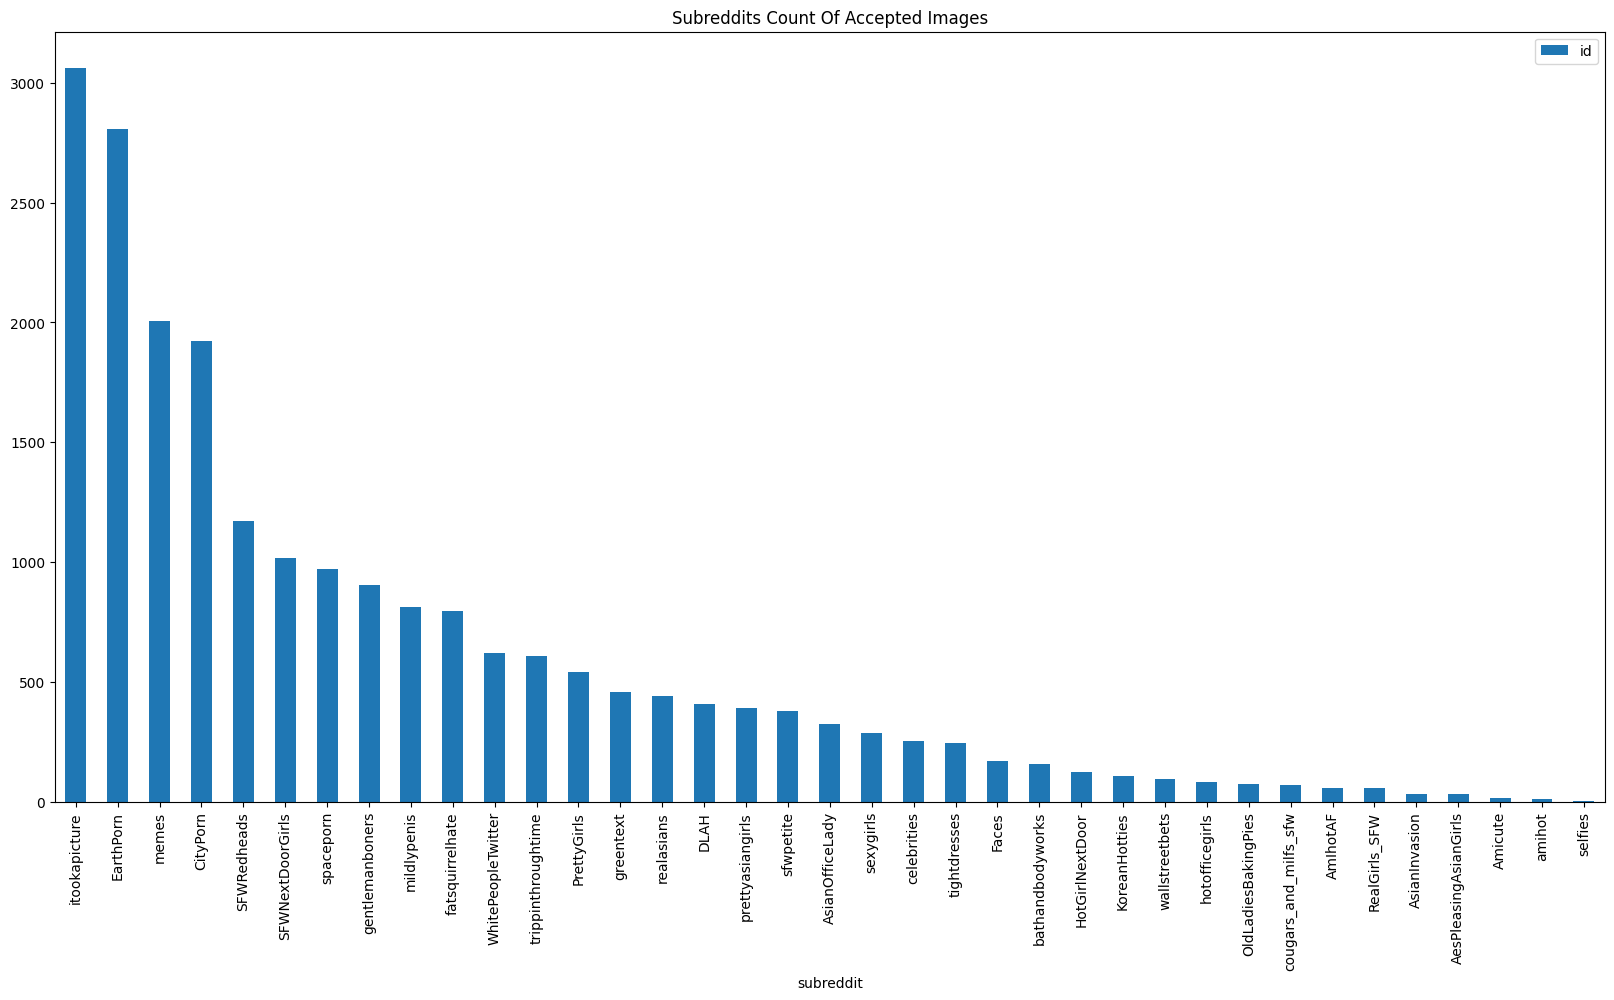

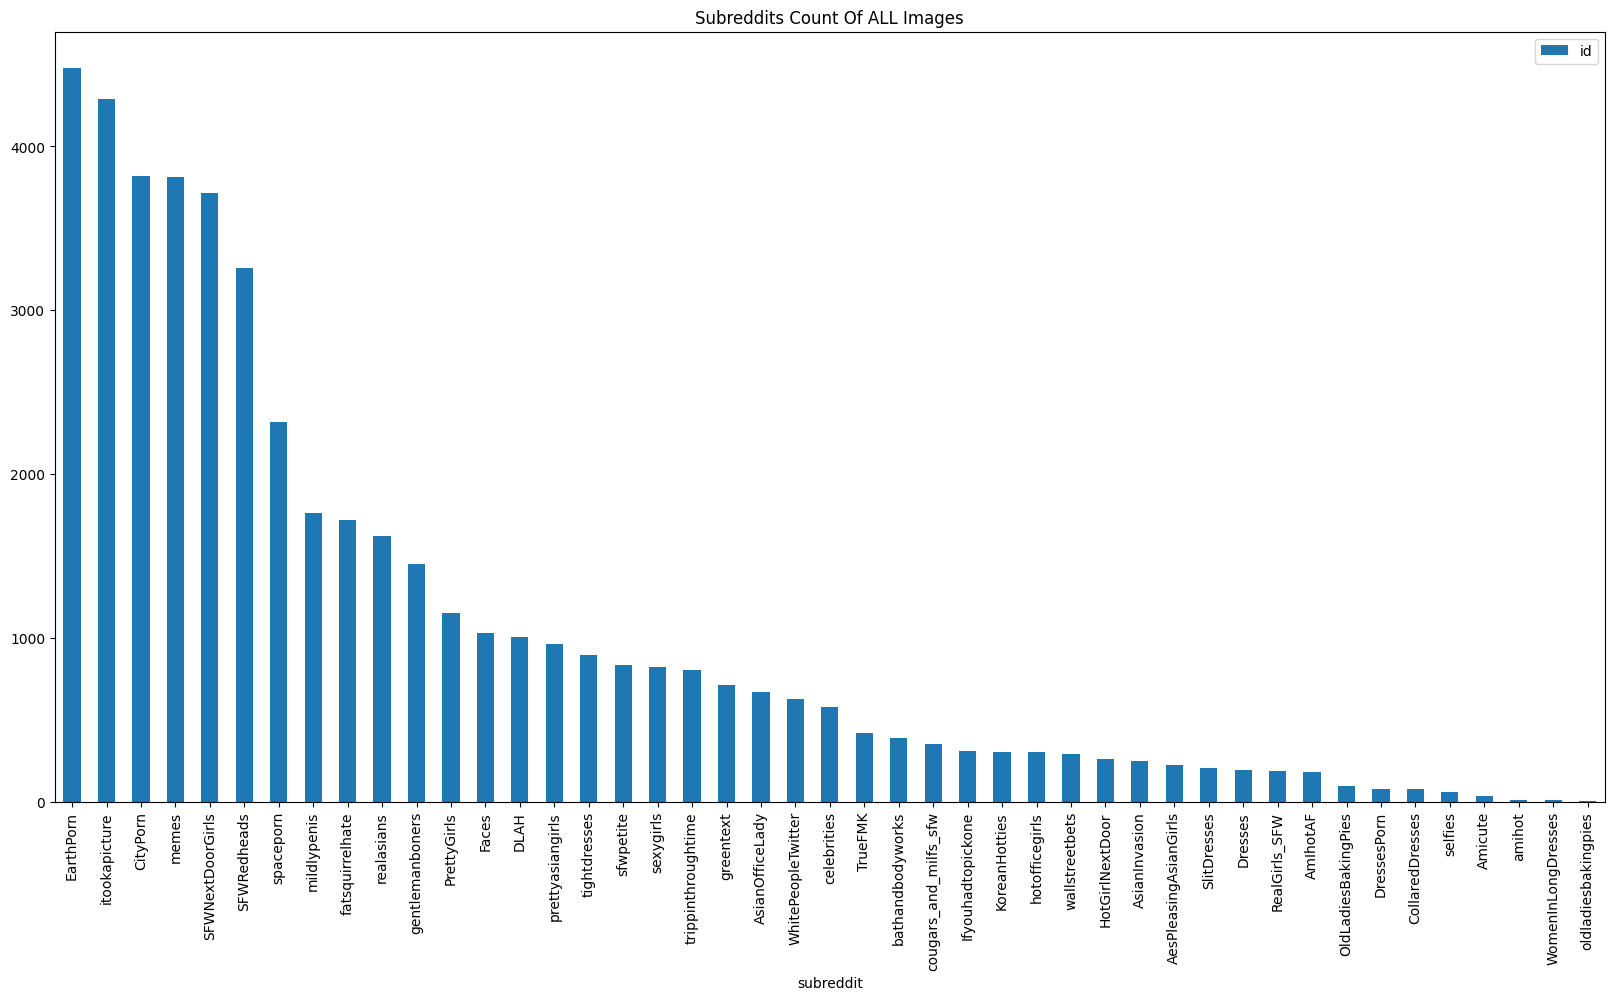

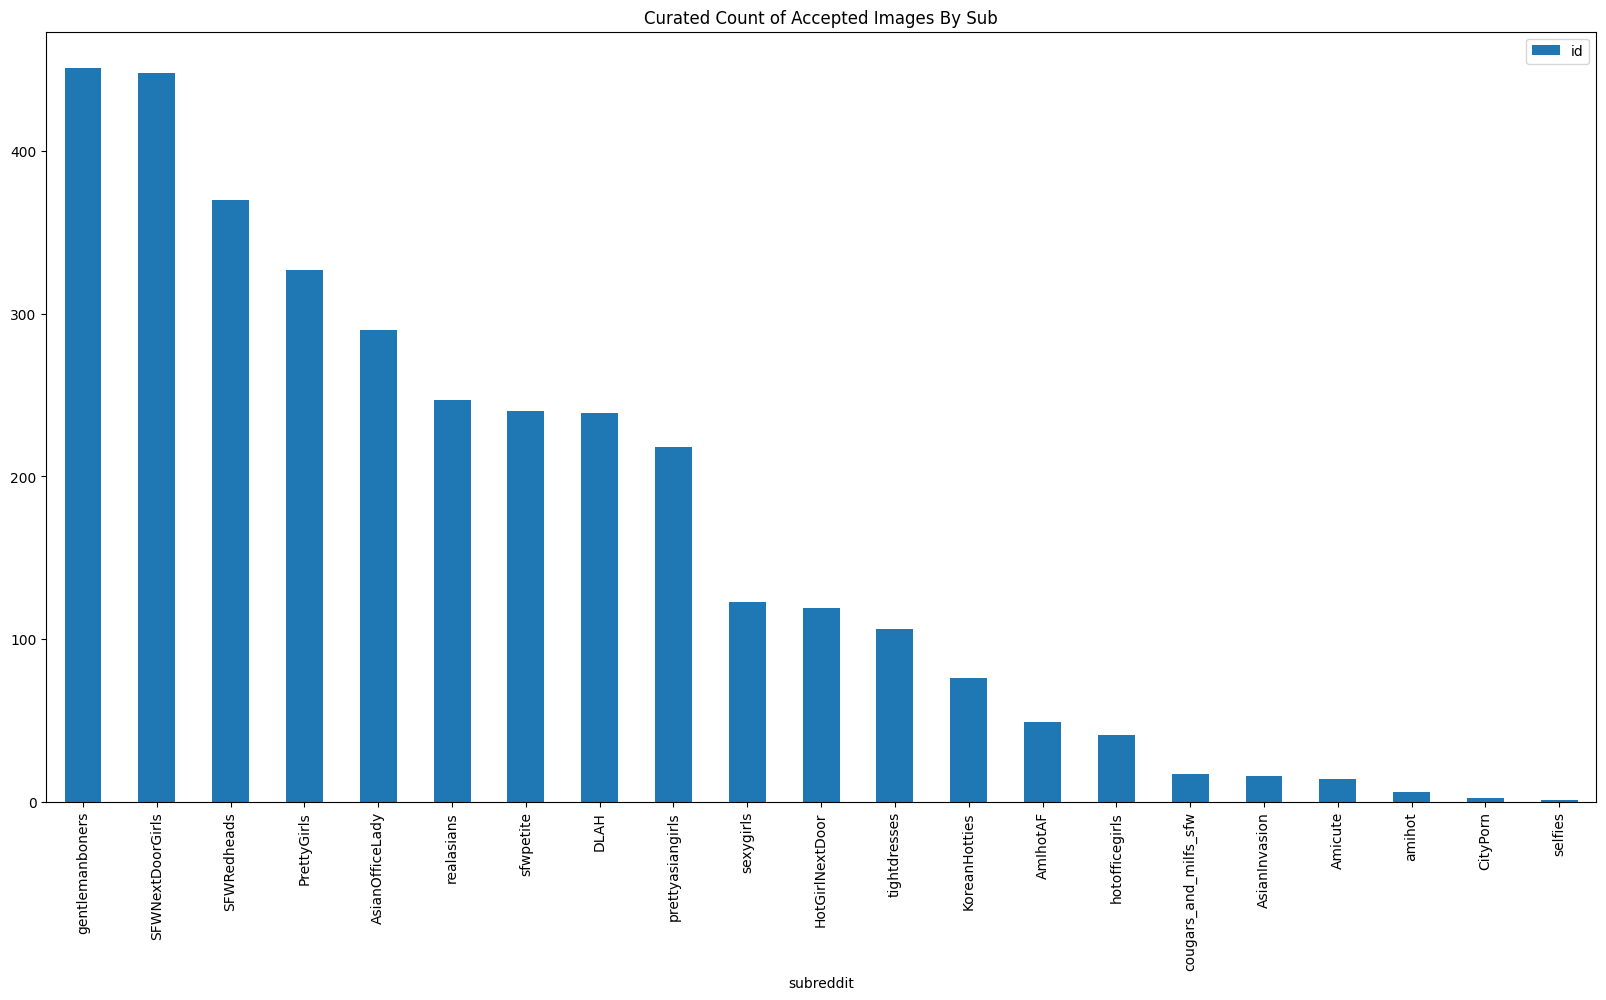

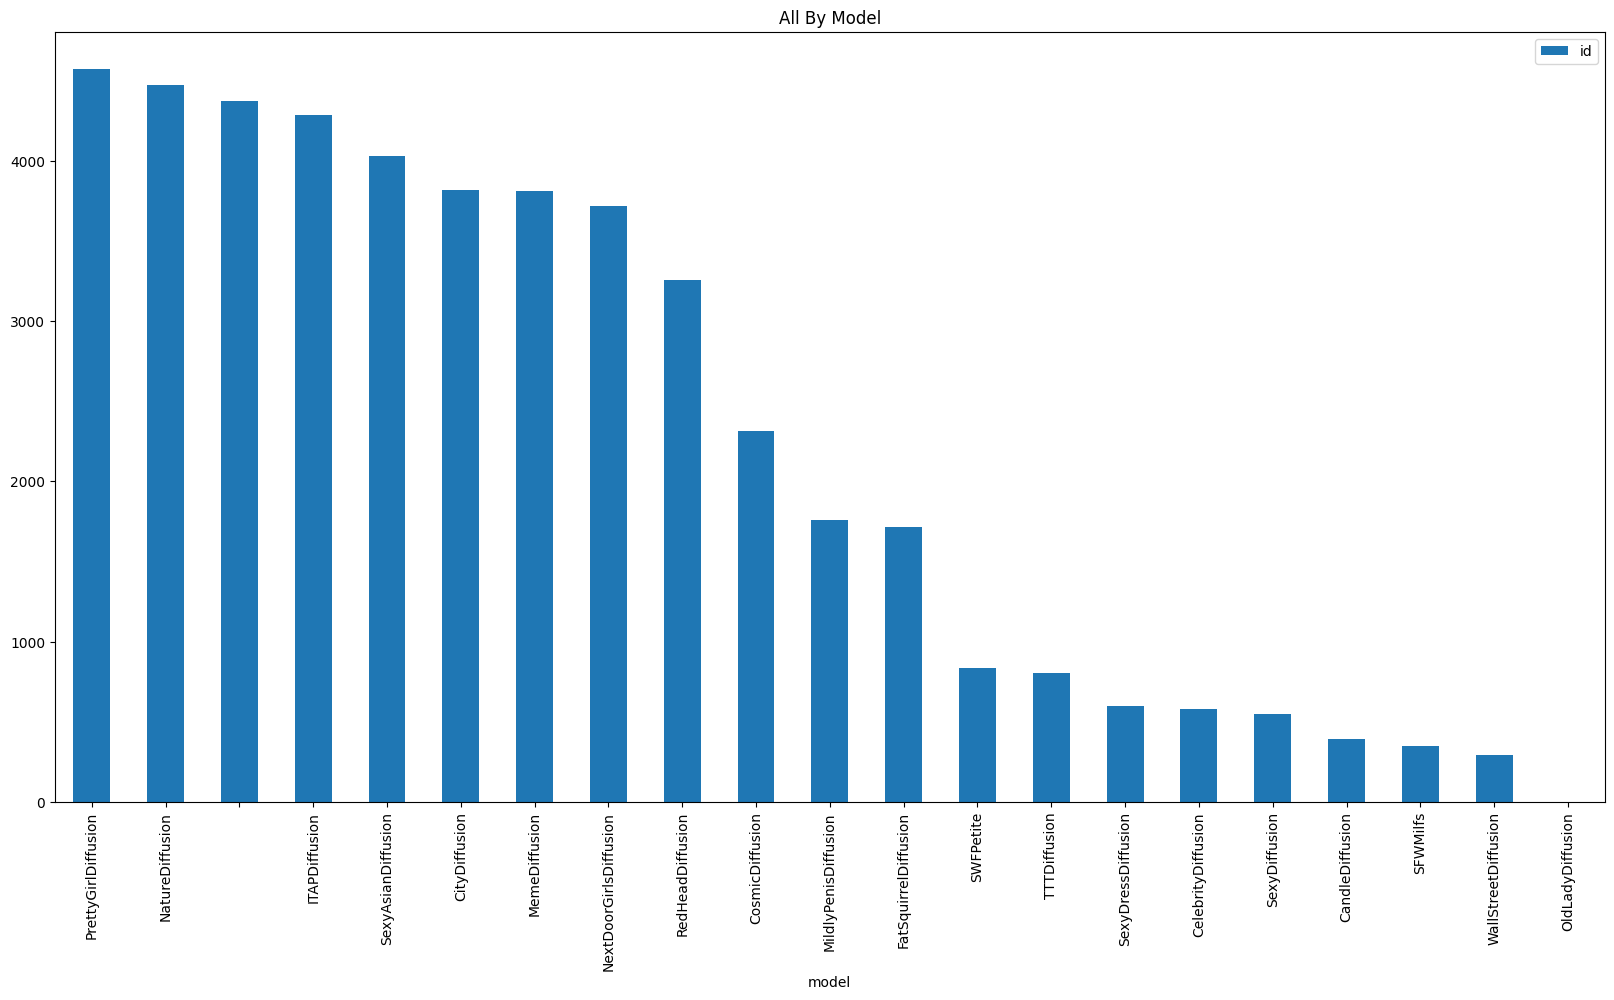

In [33]:
group = accepted_primary[["id", "subreddit"]].groupby("subreddit").count().sort_values(by="id", ascending=False)
plot = group.plot.bar(figsize=(20, 10), title="Subreddits Count Of Accepted Images", legend=True)
display(plot)

group = primary_caption[["id", "subreddit"]].groupby("subreddit").count().sort_values(by="id", ascending=False)
plot = group.plot.bar(figsize=(20, 10), title="Subreddits Count Of ALL Images", legend=True)
display(plot)

group = accepted_thumbnail[["id", "subreddit"]].groupby("subreddit").count().sort_values(by="id", ascending=False)
plot = group.plot.bar(figsize=(20, 10), title="Curated Count of Accepted Images By Sub", legend=True)
display(plot)

group = primary_caption[["id", "model"]].groupby("model").count().sort_values(by="id", ascending=False)
plot = group.plot.bar(figsize=(20, 10), title="All By Model", legend=True)
display(plot)

<Axes: title={'center': 'Models with most images'}, xlabel='model'>

<Axes: title={'center': 'Models with most images'}, xlabel='model'>

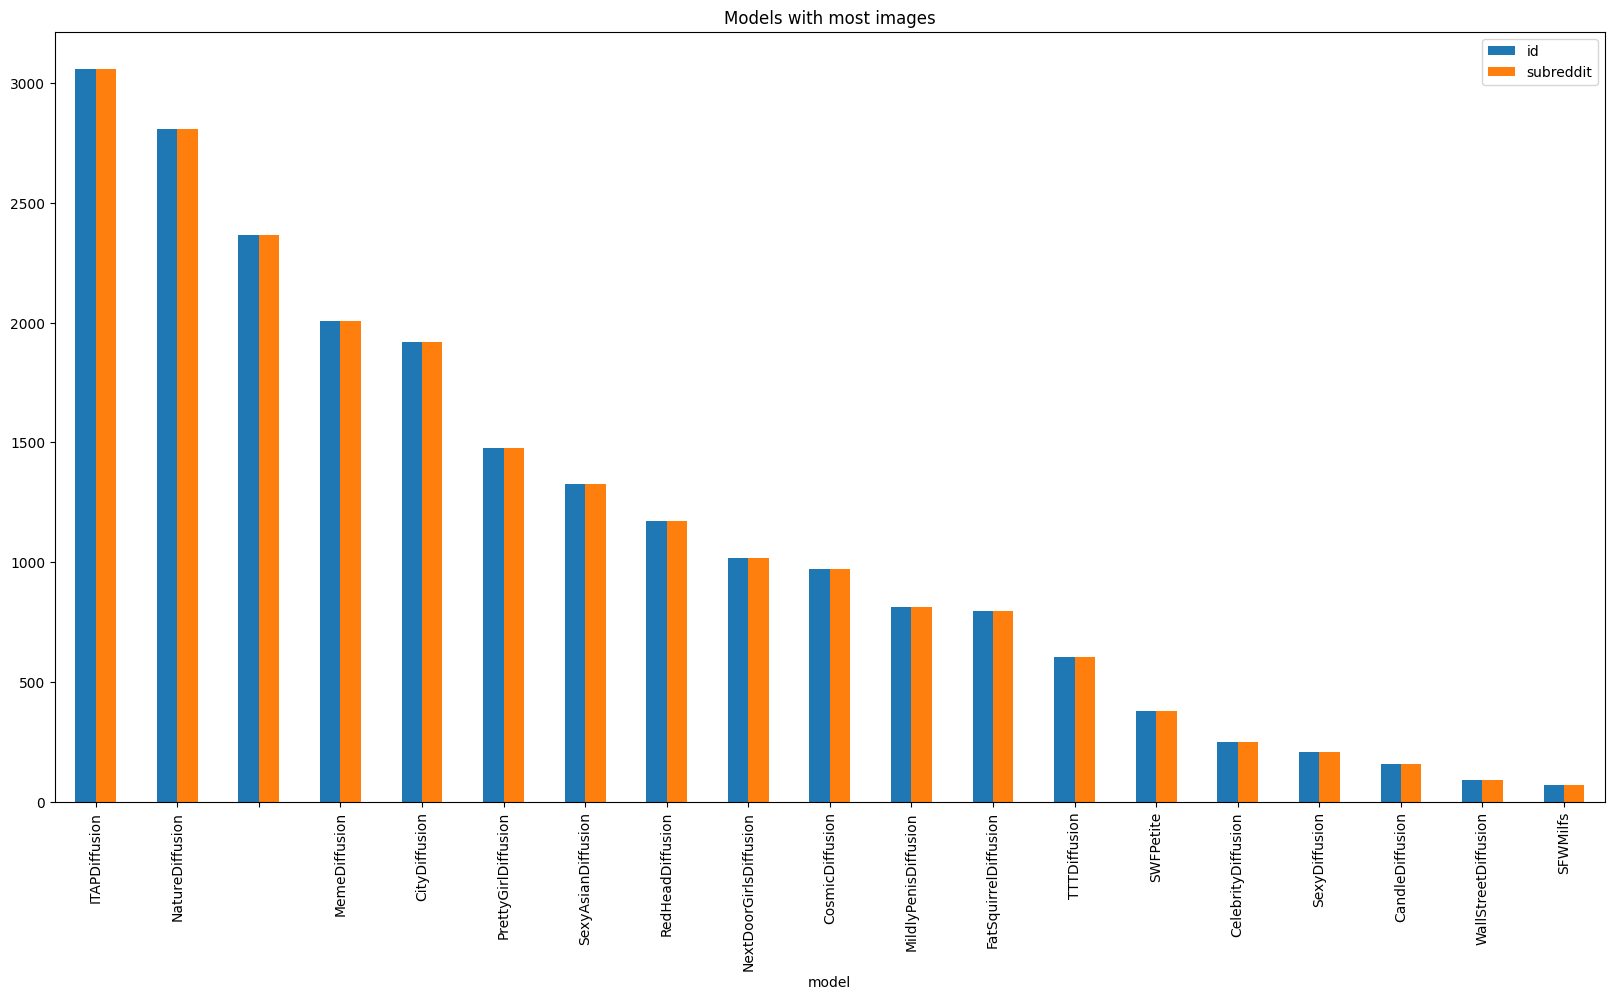

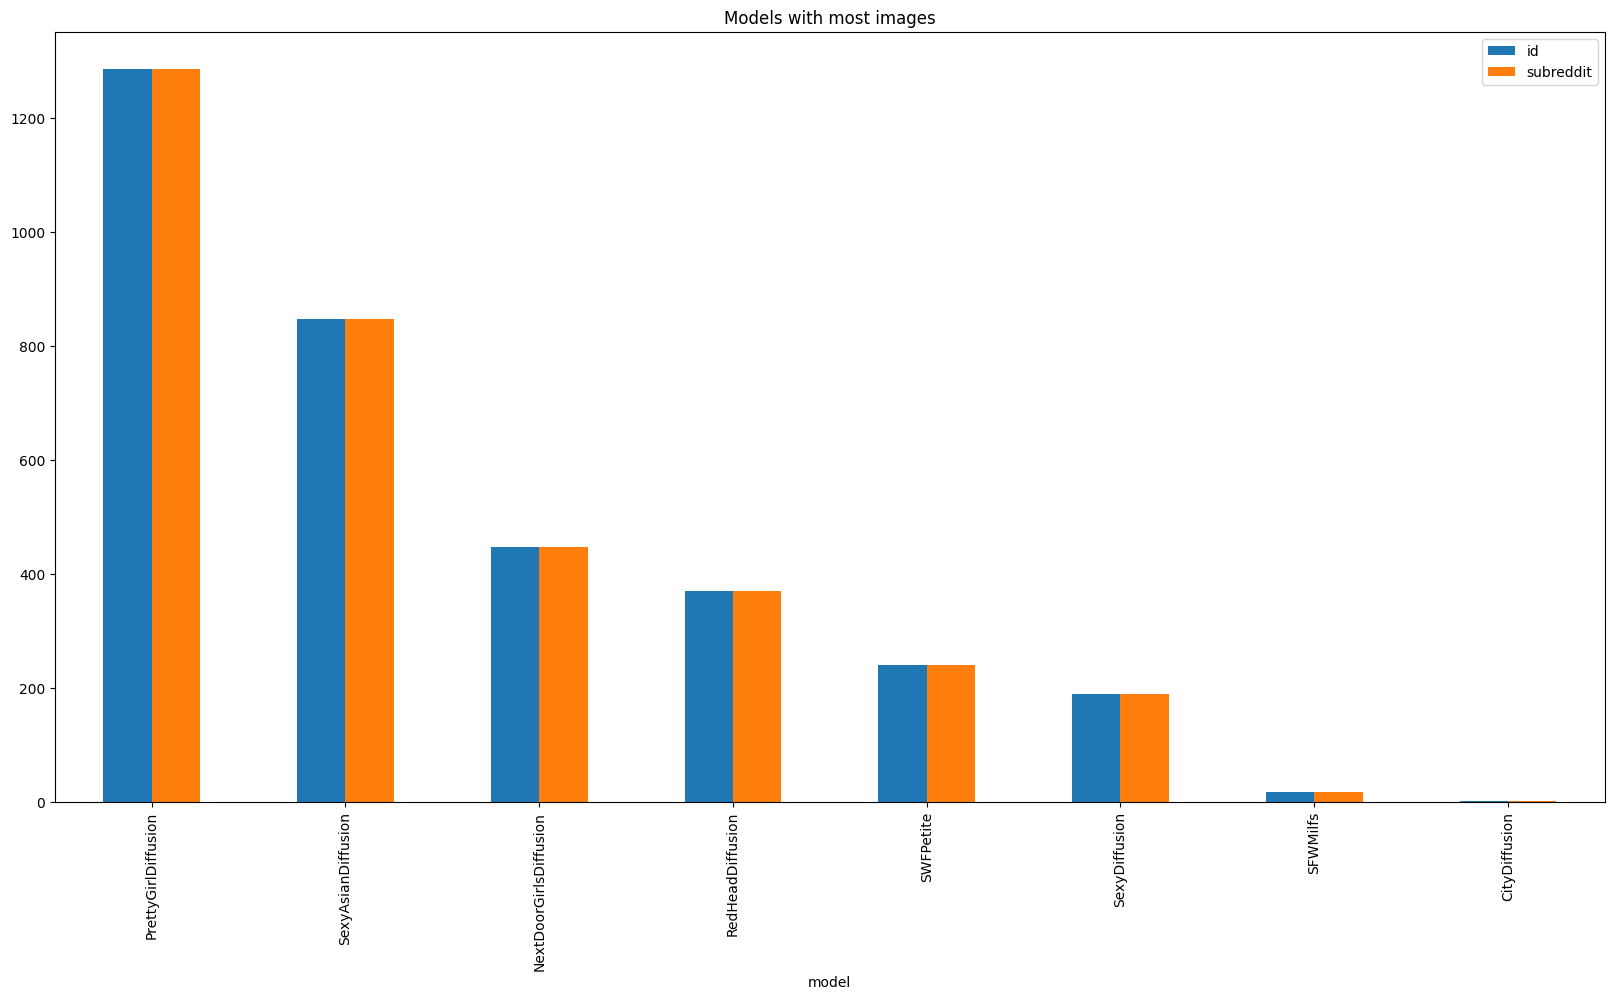

In [34]:
# @title Plot Summary: By Model Type

group = accepted_primary[["id", "model", "subreddit"]].groupby(["model"]).count().sort_values(by="id", ascending=False)
plot = group.plot.bar(figsize=(20, 10), title="Models with most images", legend=True)
display(plot)

group = accepted_thumbnail[["id", "model", "subreddit"]].groupby(["model"]).count().sort_values(by="id",
																								ascending=False)
plot_1 = group.plot.bar(figsize=(20, 10), title="Models with most images", legend=True)
display(plot)

In [35]:
# #@title Disconnect

!notebook shutdown
# from google.colab import runtime
# runtime.unassign()

'notebook' is not recognized as an internal or external command,
operable program or batch file.
